This notebook tries to search for optimal fixed policies (e.g. constant mortality) that maximize the objective (i.e. expected net reward). Here I try [scikit-optimize](https://scikit-optimize.github.io/stable/index.html) routines which are designed for noisy functions and compare to a brute-force parallel grid search.  

In [1]:
#%pip install -e ..

In [2]:
from rl4fisheries import Asm, Asm2o, Msy, ConstEsc, CautionaryRule

import polars as pl
import numpy as np
import ray
from tqdm import tqdm # progress bar
from plotnine import ggplot, aes, geom_point, geom_ribbon


## Fixed policy evaluation helpers

In [3]:
@ray.remote
def gen_ep_rew(manager, env):
    episode_reward = 0.0
    observation, _ = env.reset()
    for t in range(env.Tmax):
        action = manager.predict(observation)
        observation, reward, terminated, done, info = env.step(action)
        episode_reward += reward
        if terminated or done:
            break
    return episode_reward

def gather_stats(manager, env, N=96):
    results = ray.get([gen_ep_rew.remote(manager, env) for _ in range(N)])
    y = np.mean(results)
    sigma = np.std(results)
    ymin = y - sigma
    ymax = y + sigma
    return y, ymin, ymax 

In [4]:
env = Asm()

## MSY

In [5]:
results = []
for x in tqdm(np.linspace(0,0.25, 100)):
    manager = Msy(mortality=x)
    results.append([x, *gather_stats(manager, env=env)])

  0%|          | 0/100 [00:00<?, ?it/s]2024-02-14 05:48:02,649	WARNING services.py:1996 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67104768 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=8.96gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2024-02-14 05:48:02,784	INFO worker.py:1724 -- Started a local Ray instance.
100%|██████████| 100/100 [01:09<00:00,  1.44it/s]


In [6]:
opt_msy = max(results, key= lambda r: r[1])[0]
opt_msy

0.07070707070707072

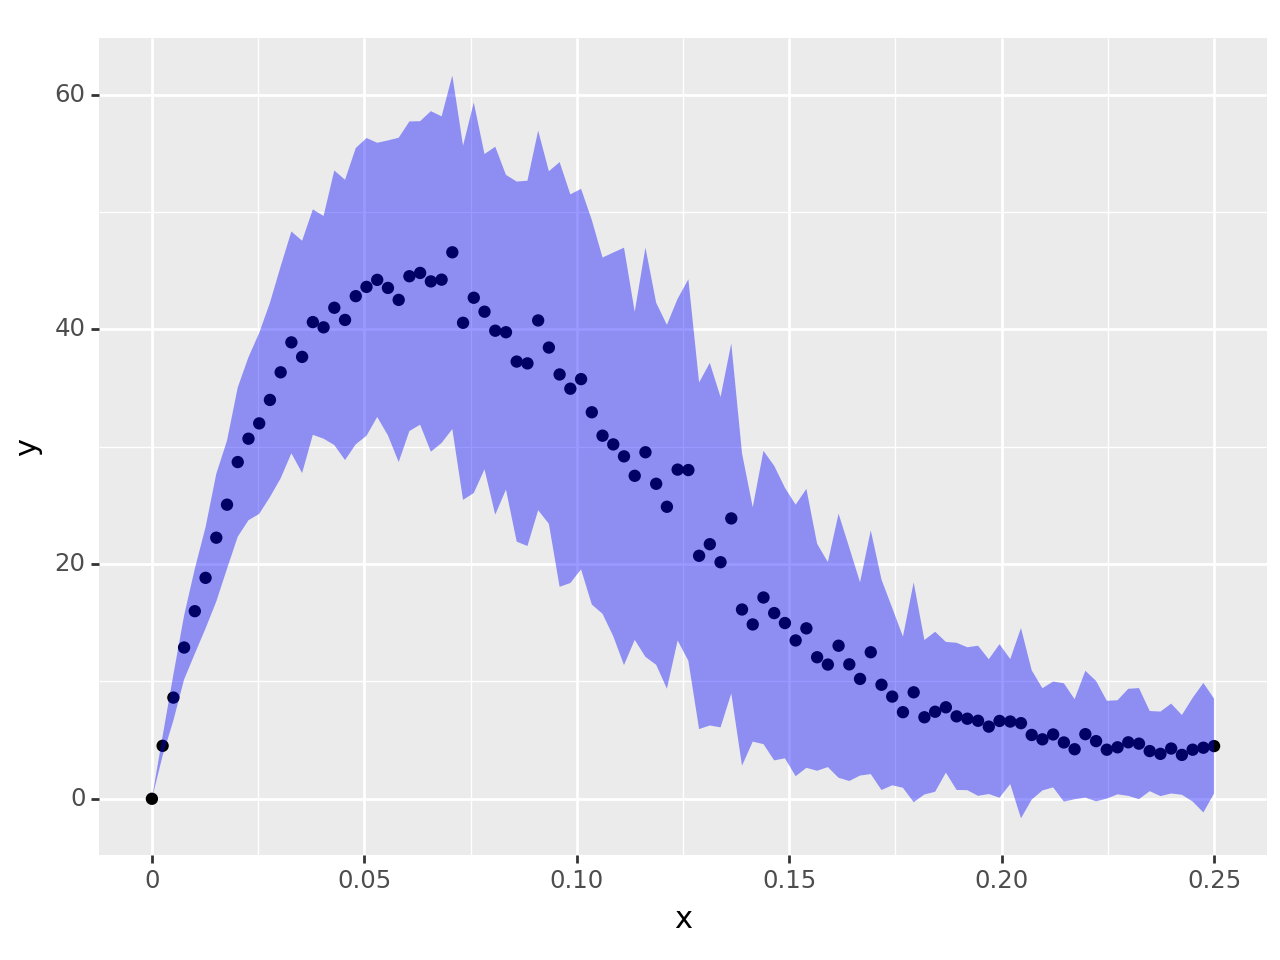

<Figure Size: (640 x 480)>

In [7]:
df = pl.from_records(results, schema=["x", "y", "ymin", "ymax"])
ggplot(df, aes("x", "y", ymin = "ymin", ymax = "ymax")) + geom_point() + geom_ribbon(alpha=0.4, fill="blue")

## Const Esc

simple version works fine:

In [8]:
class const_escapement:
    def __init__(self, escapement, obs_bound=50):
        self.obs_bound = obs_bound
        self.escapement = escapement

    def predict(self, observation, **kwargs):
        obs = (observation + 1) * self.obs_bound / 2
        harvest = np.clip(obs - self.escapement, 0, self.obs_bound)
        if obs <= 0:
            effort = np.array(0.0, dtype=np.float32)
        else:
            effort = harvest / obs
        action = 2 * effort - 1.0
        action = np.clip(action, [-1], [1])
        return np.float32(action)


100%|██████████| 100/100 [01:15<00:00,  1.33it/s]


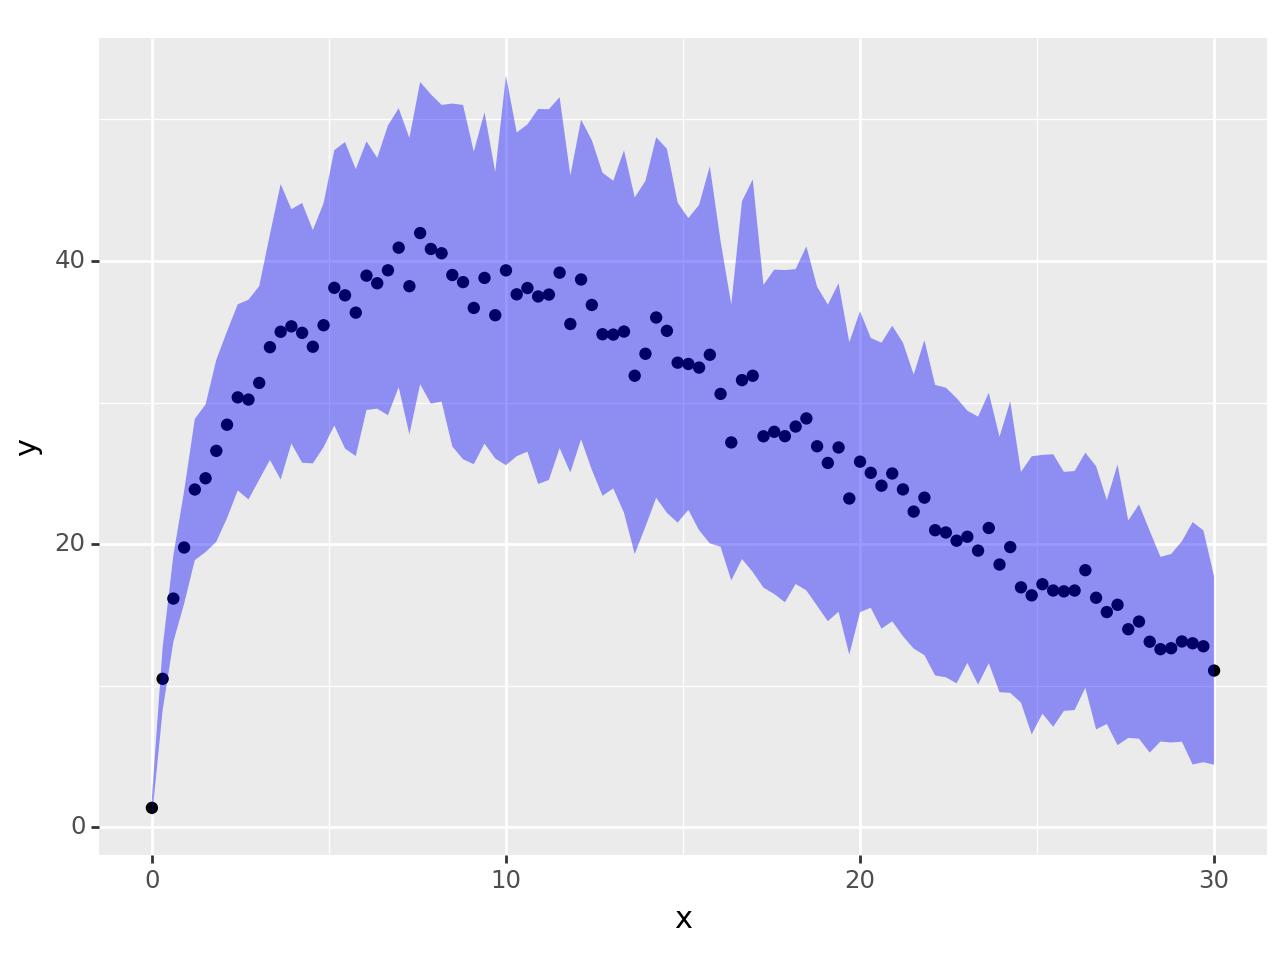

<Figure Size: (640 x 480)>

In [9]:
results = []
for x in tqdm(np.linspace(0.,30., 100)):
    manager = const_escapement(x)
    results.append([x, *gather_stats(manager, env=env)])

df = pl.from_records(results, schema=["x", "y", "ymin", "ymax"])
ggplot(df, aes("x", "y", ymin = "ymin", ymax = "ymax")) + geom_point() + geom_ribbon(alpha=0.4, fill="blue")

built-in ConstEsc agent not so much?

100%|██████████| 100/100 [01:01<00:00,  1.62it/s]


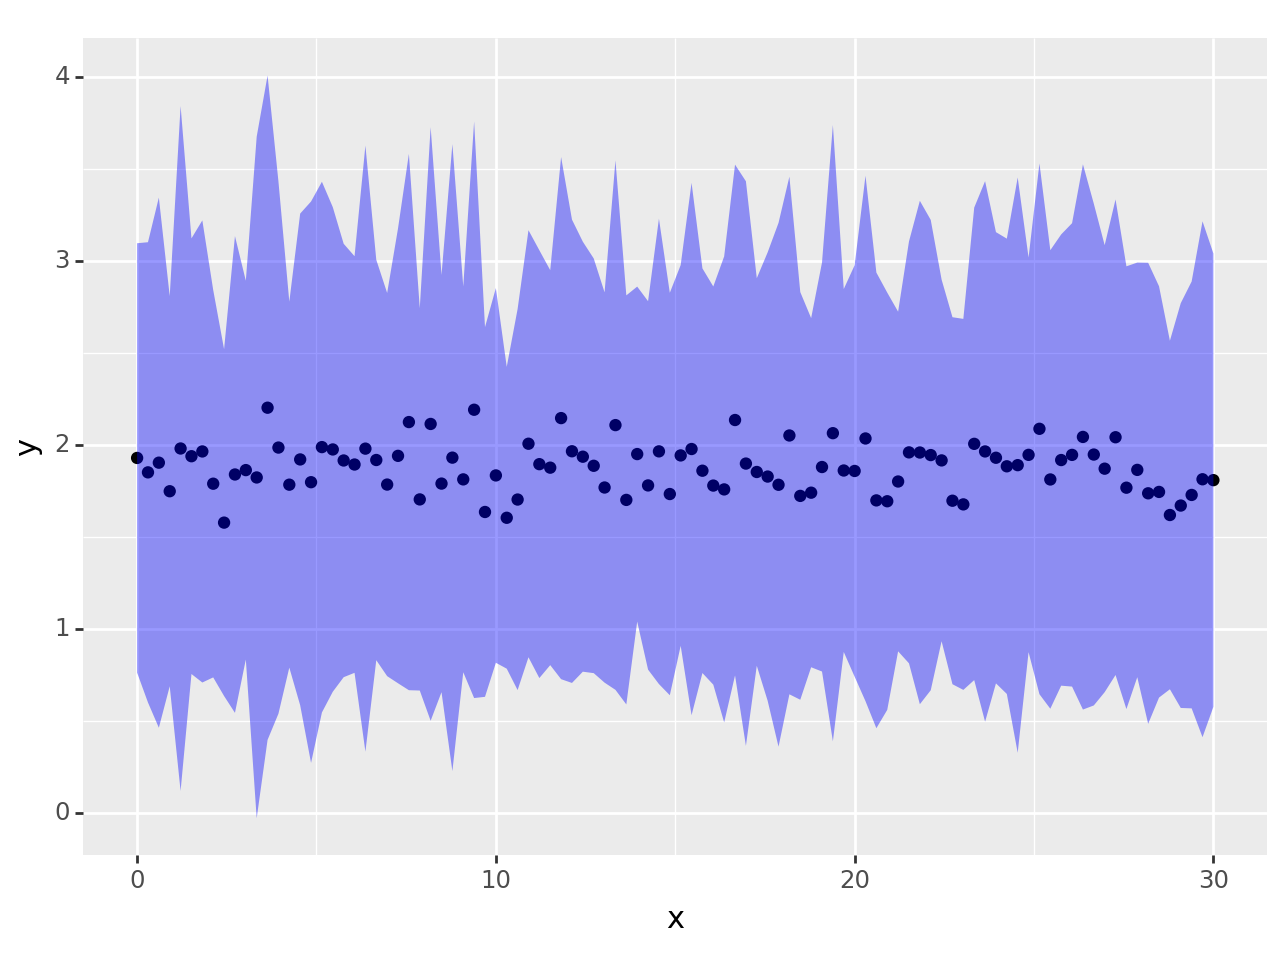

<Figure Size: (640 x 480)>

In [10]:
results = []
for x in tqdm(np.linspace(0.,30., 100)):
    manager = ConstEsc(escapement=x)
    results.append([x, *gather_stats(manager, env=env)])

df = pl.from_records(results, schema=["x", "y", "ymin", "ymax"])
ggplot(df, aes("x", "y", ymin = "ymin", ymax = "ymax")) + geom_point() + geom_ribbon(alpha=0.4, fill="blue")

In [11]:
cesc_optimum_result = max(results, key= lambda r: r[1])
cesc_optimum_result

[3.6363636363636367,
 2.2043087783049375,
 0.39918103189247267,
 4.009436524717403]

## Cautionary Rule (MSY-bootstrapped)

In [12]:
results = []
y2 = opt_msy
for radius in np.linspace(0.001, 0.5, 21):
    print(radius)
    for _ in range(100):
        theta = np.random.rand() * np.pi / 4
        x1 = np.sin(theta) * radius
        x2 = np.cos(theta) * radius 
        # sin / cos are chosen so that x1 < x2
        manager = CautionaryRule(x1=x1, x2=x2, y2=y2)
        
        results.append([x1, x2, *gather_stats(manager, env=env)])

0.001


KeyboardInterrupt: 

In [ ]:
df = pl.from_records(results, schema=["x1", "x2", "y", "ymin", "ymax"])
ggplot(df, aes("x1", "x2", color="y")) + geom_point() 

In [ ]:
cr_optimum_result = max(results, key= lambda r: r[2])

In [ ]:
cesc_optimum_result

## Gathering best results

# Using skopt

In [ ]:
from skopt import gp_minimize, gbrt_minimize 

## MSY via skopt

In [ ]:
def g(x):
    manager = Msy(mortality=x[0])
    out = gather_stats(manager, env)
    return - out[0]

In [ ]:
%%time
res = gp_minimize(g, [(0.02, 0.25)], n_calls = 100)
res.fun, res.x

In [ ]:
%%time
res = gbrt_minimize(g, [(0.02, 0.15)], n_calls = 100)
res.fun, res.x

In [ ]:
from skopt.space import Real
from skopt.utils import use_named_args

space  = [Real(0.00001, 1, name='radius'),
          Real(0.00001, np.pi/4.00001, name='theta'),
          Real(0, 0.2, name='y2')]

@use_named_args(space)
def g(**params):

    theta = params["theta"]
    radius = params["radius"]
    x1 = np.sin(theta) * radius
    x2 = np.cos(theta) * radius
    
    assert x1 <= x2, ("CautionaryRule error: x1 < x2, " + str(x1) + ", ", str(x2) )

    manager = CautionaryRule(x1 = x1, x2 =  x2, y2 = params["y2"])
    out = gather_stats(manager, env)
    return - out[0]        


In [ ]:
%%time
res_gp = gp_minimize(g, space, n_calls = 100)
res_gp.fun, res_gp.x

In [ ]:
%%time
res_gbrt = gbrt_minimize(g, space, n_calls = 100)
res_gbrt.x

In [ ]:
res = res_gbrt
manager = CautionaryRule(x1 = res.x[0], x2 = res.x[1], y2 = res.x[2])
gather_stats(manager, env=env)